# Bayesian classifiers on the Adult dataset

In [34]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import NaiveBayes, BayesianModel
from pgmpy.inference import VariableElimination

from estimators import TreeAugmentedNaiveBayesSearch, BNAugmentedNaiveBayesSearch, ForestAugmentedNaiveBayesSearch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data reading

In [2]:
df = pd.read_csv('dataset/adult.data', na_values=[' ?'])
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,high-income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


## Data pre-processing

### Strip leading and trailing spaces from column names and cell values

In [4]:
df.columns = df.columns.str.strip()
for column in df.columns.values:
    if df[column].dtype == 'object':
        df[column] = df[column].str.strip()
df.columns.values

array(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'high-income'], dtype=object)

### Removing redundant or useless features

In [5]:
useless_features = ['fnlwgt', 'education-num']
df.drop(columns=useless_features, inplace=True)
df.columns.values

array(['age', 'workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'native-country', 'high-income'], dtype=object)

### Record variable names and the target variable (`high-income`)

In [6]:
variables_names = df.columns.values
target_variable = variables_names[-1]
feature_variables = variables_names[:-1]

### Checking for NA values

In [7]:
np.sum(pd.isnull(df), 0)

age                  0
workclass         1836
education            0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
high-income          0
dtype: int64

We can drop NA values, since they are only a few, w.r.t. the size of the dataset.

In [8]:
df = df.dropna()
np.sum(pd.isnull(df), 0)

age               0
workclass         0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
high-income       0
dtype: int64

### Binning continuos variables

In [9]:
def binning(column, bins_edges, categories=None, right=False):
    '''
    Bin the given pandas Series values into specific categories names associated 
    with numerical bins. If the categories list is not given, natural numbers 
    will be used as categories.
    '''
    if column.dtype == 'object':
        return column
    bins = [(bins_edges[i], bins_edges[i + 1]) for i in range(len(bins_edges) - 1)]
    if categories is None:
        categories = list(range(len(bins)))
    if len(categories) != len(bins):
        raise Exception(
            'The lenght of the bin edges list should be one element more than the lenght of the categories list.'
        )
    _categories = dict(zip(bins, categories))
    indices = np.digitize(column, bins=bins_edges, right=right)
    values = []
    for i in range(column.size):
        values.append(
            _categories[bins[indices[i] - 1]]
        )
    return pd.Series(values, index=column.index)

The `age` variable will be divided as follows:
* `age` < 18: `child`
* 18 <= `age` < 30: `young adult`
* 30 <= `age` < 60: `adult`
* `age` >= 60: `senior`

In [10]:
_age_bins_edges = [0, 18, 30, 60, 100]
_age_categories = ['child', 'young adult', 'adult', 'senior']
df['age'] = binning(column=df['age'].copy(), bins_edges=_age_bins_edges, categories=_age_categories)
df['age'].describe()

count     30162
unique        4
top       adult
freq      19296
Name: age, dtype: object

The `hours-per-week` variable will be divided as follows:
* `hours-per-week` < 25: `part time`
* 25 <= `hours-per-week` < 40: `full time`
* 40 <= `hours-per-week` < 60: `over time`
* `hours-per-week` >= 60: `too much time`

In [11]:
_hours_bins_edges = [0, 25, 40, 60, 100]
_hours_categories = ['part time', 'full time', 'over time', 'too much time']
df['hours-per-week'] = binning(column=df['hours-per-week'].copy(), bins_edges=_hours_bins_edges, categories=_hours_categories)
df['hours-per-week'].describe()

count         30162
unique            4
top       over time
freq          20991
Name: hours-per-week, dtype: object

### Discretizing other continuos variables

The `capital-gain` and `capital-loss` variables will be quantile-based discretized. 

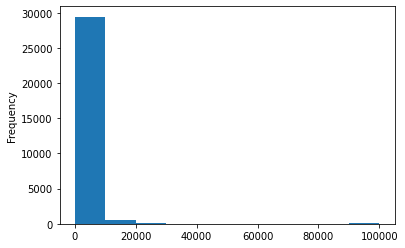

In [12]:
df['capital-gain'].plot(kind='hist')

In [13]:
df['capital-gain'], capital_gain_bins_edges = pd.qcut(df['capital-gain'], q=100, duplicates='drop', retbins=True)
df['capital-gain'].describe()

count                 30162
unique                    9
top       (-0.001, 2012.24]
freq                  27749
Name: capital-gain, dtype: object

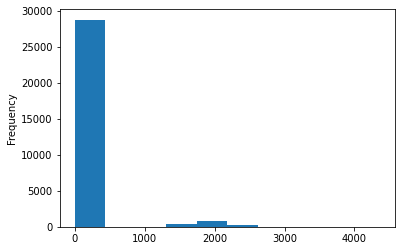

In [14]:
df['capital-loss'].plot(kind='hist')

In [15]:
df['capital-loss'], capital_loss_bins_edges = pd.qcut(df['capital-loss'], q=100, duplicates='drop', retbins=True)
df['capital-loss'].describe()

count                30162
unique                   5
top       (-0.001, 1590.0]
freq                 28963
Name: capital-loss, dtype: object

## Train/test split & utilities

In [16]:
mask = np.random.rand(len(df)) < 0.8
train = df[mask]
test = df[~mask]
test_no_target = test.copy().drop(target_variable, axis=1).reset_index()
print(f"Training set shape: {train.shape}")
print(f"Test set shape: {test.shape}")

Training set shape: (24198, 13)
Test set shape: (5964, 13)


Store every possible state for each variable:

In [57]:
state_names = {name: column.unique() for name, column in df.iteritems()}

## Prediction functions

In [18]:
def predict(data, inf, target_variable):
    '''
    Given a Dataframe, an inference object and a target variable,
    perform prediction and return the obtained results
    '''
    results = defaultdict(list)
    for _, data_point in data.iterrows():
        if 'index' in data_point:
            del data_point['index']
        result = inf.query(
            variables=[target_variable],
            evidence=data_point.to_dict(),
            show_progress=False,
        )
        values = result.state_names[target_variable]
        for i, val in enumerate(values):
            results[val].append(result.values[i])
    return results

In [19]:
def accuracy(test_data, predicted_data):
    '''
    Return a percentage representing the classification accuracy
    over the test set
    '''
    predicted_column = []
    keys = list(predicted_data.keys())
    for val in zip(*predicted_data.values()):
        max_index = np.argmax(val)
        predicted_column.append(keys[max_index])
    predicted_column = pd.Series(predicted_column, index=test_data.index)
    equality = predicted_column.eq(test_data)
    true_equality = equality[equality == True]
    return (len(true_equality) / len(test_data)) * 100

## Naive Bayes model

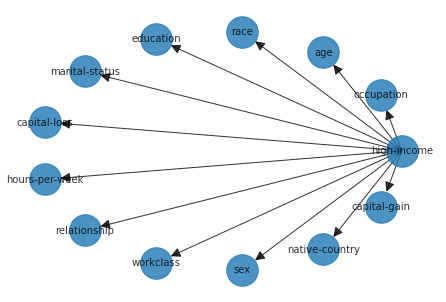

CPU times: user 807 ms, sys: 102 ms, total: 909 ms
Wall time: 330 ms


In [60]:
%%time
nb_model = NaiveBayes(
    feature_vars=feature_variables,
    dependent_var=target_variable
)
nx.draw_circular(nb_model, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)
plt.show()

### Estimate CPTs from data

In [61]:
nb_model.fit(train)
nb_cpds = nb_model.get_cpds()
if not nb_model.check_model():
    print('The NB model has errors.')
else:
    print('The NB model has no errors.')

The NB model has no errors.


### Prediction on test data

In [79]:
%%time
nb_inference = VariableElimination(nb_model)
nb_results = predict(test_no_target, nb_inference, target_variable)
nb_mean_results = {}
for k, v in nb_results.items():
    nb_mean_results[k] = np.nanmean(v)
print(nb_mean_results)

{'<=50K': 0.6753066392890199, '>50K': 0.32469336071098015}
CPU times: user 1min 47s, sys: 819 ms, total: 1min 48s
Wall time: 1min 48s


In [122]:
nb_accuracy = accuracy(test[target_variable], nb_results)
print(f'The Naive Bayes model has {round(nb_accuracy, 3)} % accuracy over the test set')

The Naive Bayes model has 80.605 % accuracy over the test set


## TAN (Tree-Augmented Naive Bayes) 

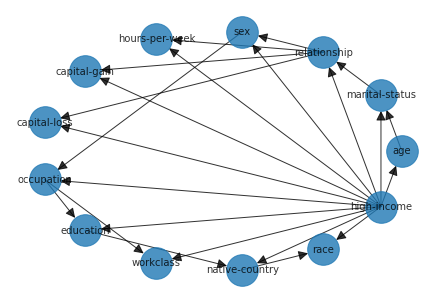

In [45]:
%%time
tan_estimator = TreeAugmentedNaiveBayesSearch(data=df, class_node=target_variable)
tan_structure = tan_estimator.estimate()
tan_model = BayesianModel(tan_structure.edges)
nx.draw_circular(tan_model, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)
plt.show()

In [70]:
tree_check = tan_structure.copy()
tree_check.remove_node(target_variable)
if nx.is_tree(tree_check):
    print('The TAN model, without the target variable, is a tree.')
else:
    print('The TAN model, without the target variable, is not a tree.')
nx.draw_circular(tree_check, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)

The TAN model, without the target variable, is a tree.


### Estimate CPTs from data

In [63]:
tan_model.fit(train, state_names=state_names)
tan_cpds = tan_model.get_cpds()
if not tan_model.check_model():
    print('The TAN model has errors.')
else:
    print('The TAN model has no errors.')

The TAN model has no errors.


### Prediction on test data

In [39]:
%%time
tan_inference = VariableElimination(tan_model)
tan_results = predict(test_no_target, tan_inference, target_variable)
tan_mean_results = {}
for k, v in tan_results.items():
    tan_mean_results[k] = np.nanmean(v)
print(tan_mean_results)

{'<=50K': nan, '>50K': nan}
CPU times: user 9min 17s, sys: 1.46 s, total: 9min 19s
Wall time: 9min 18s


In [40]:
tan_accuracy = accuracy(test[target_variable], tan_results)
print(f'The TAN model has {round(tan_accuracy, 3)} % accuracy over the test set')

The TAN model has 85.406 % accuracy over the test set


## BAN (BN-Augmented Naive Bayes)

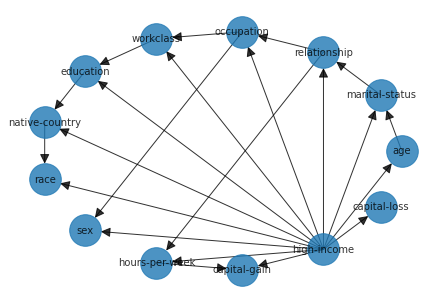

CPU times: user 934 ms, sys: 107 ms, total: 1.04 s
Wall time: 414 ms


In [27]:
%%time
ban_estimator = BNAugmentedNaiveBayesSearch(data=df, class_node=target_variable)
ban_structure = ban_estimator.estimate()
ban_model = BayesianModel(ban_structure.edges)
nx.draw_circular(ban_model, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)
plt.show()

The BAN model, without the target variable, is not a tree.


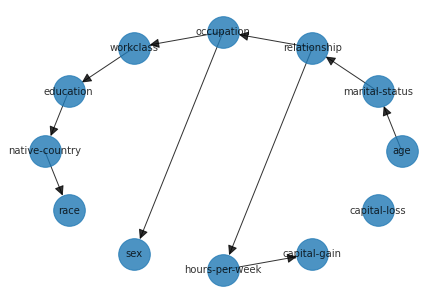

In [72]:
tree_check = ban_structure.copy()
tree_check.remove_node(target_variable)
if nx.is_tree(tree_check):
    print('The BAN model, without the target variable, is a tree.')
else:
    print('The BAN model, without the target variable, is not a tree.')
nx.draw_circular(tree_check, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)

### Estimate CPTs from data

In [64]:
ban_model.fit(train, state_names=state_names)
ban_cpds = ban_model.get_cpds()
if not ban_model.check_model():
    print('The BAN model has errors.')
else:
    print('The BAN model has no errors.')

The BAN model has no errors.


### Prediction on test data

In [31]:
%%time
ban_inference = VariableElimination(ban_model)
ban_results = predict(test_no_target, ban_inference, target_variable)
ban_mean_results = {}
for k, v in ban_results.items():
    ban_mean_results[k] = np.nanmean(v)
print(ban_mean_results)

{'<=50K': 0.7320577106360082, '>50K': 0.2679422893639918}
CPU times: user 7min 57s, sys: 1.62 s, total: 7min 59s
Wall time: 7min 59s


In [32]:
ban_accuracy = accuracy(test[target_variable], ban_results)
print(f'The BAN model has {round(ban_accuracy, 3)} % accuracy over the test set')

The BAN model has 84.373 % accuracy over the test set


## FAN (Forest-Augmented Naive Bayes)

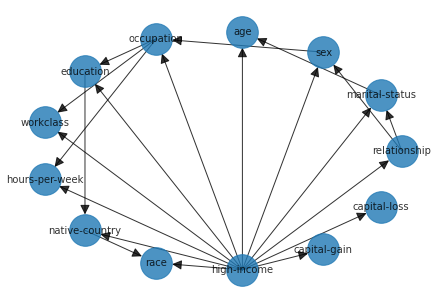

CPU times: user 14.6 s, sys: 160 ms, total: 14.8 s
Wall time: 14.2 s


In [42]:
%%time
fan_estimator = ForestAugmentedNaiveBayesSearch(data=df, class_node=target_variable)
fan_structure = fan_estimator.estimate()
fan_model = BayesianModel(fan_structure.edges)
nx.draw_circular(fan_model, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)
plt.show()

The FAN model, without the target variable, is a forest.


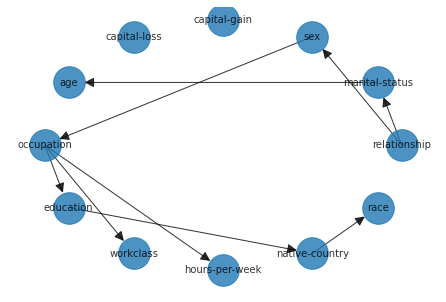

In [71]:
forest_check = fan_structure.copy()
forest_check.remove_node(target_variable)
if nx.is_forest(forest_check):
    print('The FAN model, without the target variable, is a forest.')
else:
    print('The FAN model, without the target variable, is not a forest.')
nx.draw_circular(forest_check, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)

### Estimate CPTs from data

In [65]:
fan_model.fit(train, state_names=state_names)
fan_cpds = fan_model.get_cpds()
if not fan_model.check_model():
    print('The FAN model has errors.')
else:
    print('The FAN model has no errors.')

The FAN model has no errors.


### Prediction on test data

In [50]:
%%time
fan_inference = VariableElimination(fan_model)
fan_results = predict(test_no_target, fan_inference, target_variable)
fan_mean_results = {}
for k, v in fan_results.items():
    fan_mean_results[k] = np.nanmean(v)
print(fan_mean_results)

{'<=50K': 0.734165856861706, '>50K': 0.26583414313829395}
CPU times: user 8min 25s, sys: 1.44 s, total: 8min 26s
Wall time: 8min 26s


In [51]:
fan_accuracy = accuracy(test[target_variable], fan_results)
print(f'The FAN model has {round(fan_accuracy, 3)} % accuracy over the test set')

The FAN model has 84.591 % accuracy over the test set


## Summary

### Accuracy

In [56]:
indexes = ['NB', 'TAN', 'BAN', 'FAN']
accuracies = [nb_accuracy, tan_accuracy, ban_accuracy, fan_accuracy]
accuracy_df = pd.Series(data=accuracies, index=indexes, name='accuracy')
accuracy_df

NB      0.000000
TAN     0.000000
BAN    84.372904
FAN    84.590879
Name: accuracy, dtype: float64